```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Run deterministic forecast for comparison with OpenDrift and NorKyst.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime

from IPython.display import display

import matplotlib

from matplotlib import pyplot as plt
#Set large figure sizes
#plt.rcParams["animation.html"] = "jshtml" #Javascript 
plt.rcParams["animation.html"] = "html5" #mp4
plt.rcParams["figure.dpi"] = 100.0 #highres movies/plots

plt.rcParams["animation.writer"] = 'ffmpeg' 
plt.rcParams["animation.codec"] = 'h264' 

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import CDKLM16, Common, IPythonMagic, NetCDFInitialization
from SWESimulators import GPUDrifterCollection, Observation
from SWESimulators import DataAssimilationUtils as dautils

from demos.realisticSimulations import norkyst_plotting

In [3]:
%cuda_context_handler gpu_ctx

# Select area and result folder

In [4]:
case_name = 'lovese'

netcdf_frequency_hours = 6

start_forecast_hours = 48
end_forecast_hours = start_forecast_hours + 47

# How many cells to erode of land
erode_land=1

out_folder = os.path.abspath('deterministic_forecast_'+datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))

os.makedirs(out_folder, exist_ok=True)
print("Output will be placed in '" + out_folder + "'")

Output will be placed in '/home/havahol/playground/gpu-ocean/havahol-gpu-ocean/gpu_ocean/demos/MPI_SIR/deterministic_forecast_2019_12_06-10_09_45'


# Inspect URL and select area

In [5]:
url_list = [
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071900.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072000.nc',
    'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019072100.nc'
]


# Create simulator

In [6]:
# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "rk_order": 2,
    "desingularization_eps": 1.0
}
data_args = NetCDFInitialization.getInitialConditionsNorKystCases(url_list, case_name, 
                                                                  timestep_indices=None, 
                                                                  erode_land=erode_land,
                                                                  download_data=False)

importlib.reload(CDKLM16)
sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))

forecast_netcdf = os.path.join(out_folder, case_name + "_deterministic_forecast.nc")



This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


# Observation and forecast

In [7]:
observation_filename = '2019-12-03/lovese/opendrift_observations_18_08_56.pickle'
observation_args = {'observation_type': dautils.ObservationType.UnderlyingFlow,
                    'nx': sim.nx, 'ny': sim.ny,
                    'domain_size_x': sim.nx*sim.dx,
                    'domain_size_y': sim.ny*sim.dy,
                    'land_mask': sim.getLandMask()
                   }
observations = Observation.Observation(**observation_args)
observations.read_pickle(observation_filename)


trajectory_forecast = Observation.Observation(**observation_args)

trajectory_forecast_filename = 'trajectory_forecast_'+str(start_forecast_hours)+'_to_'+str(end_forecast_hours)+'.pickle'
trajectory_forecast_path = os.path.join(out_folder, trajectory_forecast_filename)

# Create drifters (but do not attach them)

In [8]:
drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, observations.get_num_drifters(),
                                                     boundaryConditions = sim.boundary_conditions,
                                                     domain_size_x = observations.domain_size_x,
                                                     domain_size_y = observations.domain_size_y,
                                                     gpu_stream = sim.gpu_stream)


# Running the simulation

In [9]:

assert (not os.path.isfile(forecast_netcdf)), 'The deterministic forecast is already run. Restart run all, bitte :)'


try:
    ncfile = Dataset(forecast_netcdf, 'w')

    var = {}
    var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=False)
    _, var['Hm'] = sim.downloadBathymetry(interior_domain_only=False)

    ny, nx = var['eta'].shape

    # Create dimensions
    ncfile.createDimension('time', None) # unlimited
    ncfile.createDimension('x', nx)
    ncfile.createDimension('y', ny)

    ncvar = {}

    # Create variables for dimensions
    ncvar['time'] = ncfile.createVariable('time', 'f8', ('time',))
    ncvar['x'] = ncfile.createVariable('x', 'f4', ('x',))
    ncvar['y'] = ncfile.createVariable('y', 'f4', ('y',))

    # Fill dimension variables
    ncvar['x'][:] = np.linspace(0, nx*sim.dx, nx)
    ncvar['y'][:] = np.linspace(0, ny*sim.dy, ny)

    # Create static variables
    ncvar['Hm'] = ncfile.createVariable('Hm', 'f8', ('y', 'x',), zlib=True)
    ncvar['Hm'][:,:] = var['Hm'][:,:]

    # Create time varying data variables
    for varname in ['eta', 'hu', 'hv']:
        ncvar[varname] = ncfile.createVariable(varname, 'f8', ('time', 'y', 'x',), zlib=True)
    ncvar['num_iterations'] = ncfile.createVariable('num_iterations', 'i4', ('time',))


    ###
    ###  SIMULATION
    ###
    
    num_total_hours = end_forecast_hours
    
    five_mins_in_an_hour = 12
    sub_dt = 5*60 # five minutes
    
    progress = Common.ProgressPrinter(5)
    pp = display(progress.getPrintString(0), display_id=True)

    netcdf_counter = 0
    for hour in range(num_total_hours):
        
        if hour == start_forecast_hours:
            # Attach drifters
            drifter_positions = observations.get_drifter_position(sim.t)
            drifters.setDrifterPositions(drifter_positions)
            sim.attachDrifters(drifters)
            trajectory_forecast.add_observation_from_sim(sim)
        
        for mins in range(five_mins_in_an_hour):
            t = sim.step(sub_dt)
            if hour >= start_forecast_hours:
                trajectory_forecast.add_observation_from_sim(sim)
            
        if hour % netcdf_frequency_hours == 0:
            var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=False)
            ncvar['time'][netcdf_counter] = sim.t
            ncvar['num_iterations'][netcdf_counter] = sim.num_iterations

            abort=False
            for varname in ['eta', 'hu', 'hv']:
                ncvar[varname][netcdf_counter,:,:] = var[varname][:,:] #np.ma.masked_invalid(var[varname][:,:])
                if (np.any(np.isnan(var[varname]))):
                    print("Variable " + varname + " contains NaN values!")
                    abort=True
            netcdf_counter += 1

            if (abort):
                print("Aborting at t=" + str(sim.t))
                ncfile.sync()
                break
        
        pp.update(progress.getPrintString(hour/(end_forecast_hours-1)))

except Exception as e:
    print("Something went wrong:" + str(e))
    raise e
finally:
    ncfile.close()
    
trajectory_forecast.to_pickle(trajectory_forecast_path)

'0% [##############################] 100%. Total: 20m 20s, elapsed: 20m 20s, remaining: 0s'

# Plot final state

'0% [==============================] 100%. Total: nan, elapsed: 0s, remaining: nan'

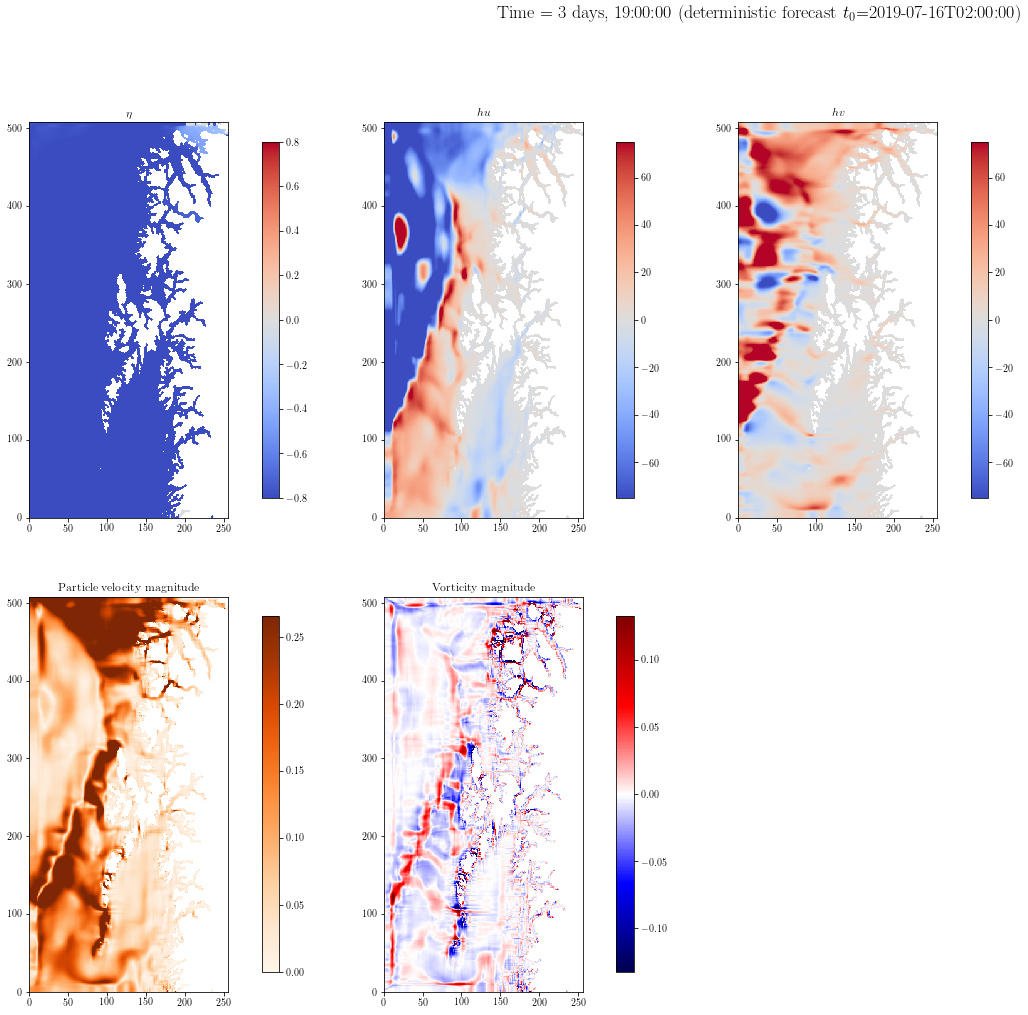

In [10]:
norkyst_plotting.ncAnimation(forecast_netcdf,
             title="deterministic forecast $t_0$=" + datetime.datetime.fromtimestamp(data_args['t0']).isoformat(timespec='seconds'),
             movie_frames=200, 
             create_movie=False,
             fig=plt.figure(figsize=(18,16)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=2,
             rotate=True, 
             downsample=2)

# Forecasted trajectories

In [13]:
def forecastPlot(ax, true_paths, ensemble_paths, color_id=0, 
                 forecast_point_size=2, truth_point_size=6, mean_paths=[None]):
    """
    ax: Axis object to draw trajectories in
    true_path: A single list of paths that represents the truth
    ensemble_paths: Multiple lists of paths that represents the forecast
    color_id: integer representing a pre-defined color combination.
    """

    color_combinations = [
        # [true color, forecast color]
        #['xkcd:dark grey blue', 'xkcd:light blue grey', 'xkcd:wine'],
        ['xkcd:scarlet', 'xkcd:light blue grey', 'xkcd:dark grey blue'],
        ['xkcd:viridian', 'xkcd:foam green']
    ]
    
    assert(color_id < len(color_combinations)), 'Invalid color_id'
    
    true_color = color_combinations[color_id][0]
    forecast_color = color_combinations[color_id][1]
    mean_color = color_combinations[color_id][2]

    # Plot forecast paths 
    for paths in ensemble_paths:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=forecast_color, alpha=0.3)
        
        # Mark end position of forecast
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                      forecast_point_size, 
                                                      fill=False, zorder=10,
                                                      alpha=0.7)
        ax.add_patch(circ_end_forecast)

    
    # Plot true path
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=true_color, zorder=5)
    
    # Plot mean path
    if mean_paths[0] is not None:
        for path in mean_paths:
            ax.plot(path[:,0], path[:,1], color=mean_color, zorder=6)
    
    # Mark start and end of true path
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           truth_point_size,
                                           fill=False, zorder=10)
    ax.add_patch(circ_start)
    #circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
    #                                     truth_point_size,
    #                                     fill=False, zorder=10)
    #ax.add_patch(circ_end)
    ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)
    
    # Mark end of mean path
    if mean_paths[0] is not None:
        #xend = matplotlib.patches.Circle((mean_paths[-1][-1,0], mean_paths[-1][-1,1]),
        #                                 truth_point_size,
        #                                 fill=False, zorder=10)
        #ax.add_patch(xend)
        ax.plot(mean_paths[-1][-1,0], mean_paths[-1][-1,1], 
                   marker='o', markeredgecolor='k', markerfacecolor=None)
        
def createForecastCanvas(observation):
    """
    true_sim_reader: The SimReader object containing nx, ny, etc
    """   
    
    nx = observation.nx
    ny = observation.ny
    
    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    
    extent=np.array([0, observation.domain_size_x, 0, observation.domain_size_y])/1000
    ax.imshow(observation.land_mask, origin="lower", 
              extent=extent, cmap='binary')

    return ax


def plotAllDrifters(obs_file, drifter_ids=None):
    
    if drifter_ids is None:
        drifter_ids = np.arange(obs_file.get_num_drifters(ignoreBuoys=True))
    
    num_drifters = len(drifter_ids)
    
    drifter_paths = [None]*num_drifters

    forecast_start_t = start_forecast_hours*3600
    forecast_end_t = end_forecast_hours*3600


    for i in range(num_drifters):
        drifter_paths[i] = obs_file.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t)

    ax = createForecastCanvas(trajectory_forecast)
    for drifter_path in drifter_paths:
        forecastPlot(ax, drifter_path, [], truth_point_size=1)


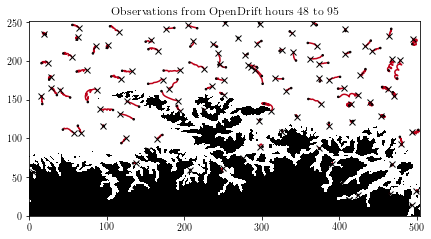

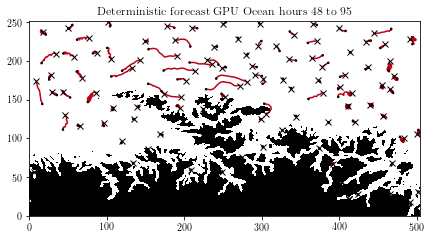

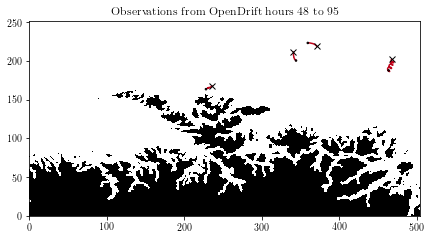

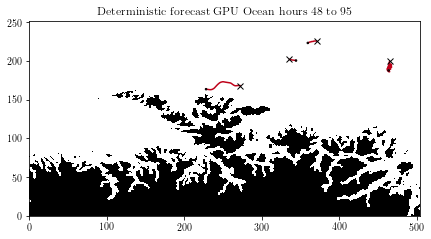

In [15]:
dt_string = 'hours ' + str(start_forecast_hours) + ' to ' + str(end_forecast_hours)

plotAllDrifters(observations)
plt.title('Observations from OpenDrift '+ dt_string)
plt.savefig(os.path.join(out_folder, 'opendrift_observations.pdf'))

plotAllDrifters(trajectory_forecast)
plt.title('Deterministic forecast GPU Ocean ' + dt_string)
plt.savefig(os.path.join(out_folder, 'gpuocean_forecasts.pdf'))

selected_drifters = [103, 84, 85, 41]
plotAllDrifters(observations, drifter_ids=selected_drifters)
plt.title('Observations from OpenDrift '+ dt_string)
plt.savefig(os.path.join(out_folder, 'opendrift_observations_subset.pdf'))

plotAllDrifters(trajectory_forecast, drifter_ids=selected_drifters)
plt.title('Deterministic forecast GPU Ocean ' + dt_string)
plt.savefig(os.path.join(out_folder, 'gpuocean_forecasts_subset.pdf'))